## Importaciones

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

## Cargar Dataset

In [3]:
# Datos simulados para una semana (7 días) con 48 pings diarios (cada 30 minutos)
users = [1, 2, 3]  # 3 usuarios
days = list(range(7))  # 7 días (una semana)
hours = list(range(48))  # 48 "horas" para representar los pings

# Crear un dataset simulado
data = []
for user in users:
    for day in days:
        for hour in hours:
            x = np.random.randint(0, 200)  # Coordenada X aleatoria
            y = np.random.randint(0, 200)  # Coordenada Y aleatoria
            data.append([user, day, hour, x, y])

# Crear DataFrame
df = pd.DataFrame(data, columns=['user', 'day', 'hour', 'x', 'y'])
print("Dataset creado:")
print(df.head())

Dataset creado:
   user  day  hour    x    y
0     1    0     0  129   91
1     1    0     1    5   42
2     1    0     2   34  158
3     1    0     3  177  157
4     1    0     4  166    3


## Preprocesamiento y Creación de Secuencias

In [4]:
# Preprocesamiento
scaler = MinMaxScaler()
numerical_cols = ['day', 'hour', 'x', 'y']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Creación de secuencias
def create_sequences(data, seq_length):
    X, y = [], []
    if len(data) < seq_length + 1:  # Validación
        raise ValueError(f"Insufficient data: need at least {seq_length+1} rows, but got {len(data)}")

    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

seq_length = 7  # Ventana de una semana
X, y = create_sequences(df[numerical_cols].values, seq_length)

# Dataset y DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TimeSeriesDataset(X, y)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

C:\Users\Brian_iq\AppData\Local\Temp\ipykernel_37528\3222542816.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


## Modelos


In [5]:
# Modelo Simple NN
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplanar
        x = self.fc1(x)
        x = self.relu(x)
        return self.fc2(x)

# Modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# Modelo GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hn = self.gru(x)
        return self.fc(hn[-1])

# Modelo RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hn = self.rnn(x)
        return self.fc(hn[-1])


## Función de Entrenamiento

In [8]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []  # Almacena las pérdidas
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_loss = total_loss / len(dataloader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
    return losses  # Asegúrate de retornar las pérdidas


## Entrenamiento y Gráficas Comparativas

Entrenando SimpleNN...
Epoch [1/10], Loss: 0.0742
Epoch [2/10], Loss: 0.0528
Epoch [3/10], Loss: 0.0502
Epoch [4/10], Loss: 0.0490
Epoch [5/10], Loss: 0.0486
Epoch [6/10], Loss: 0.0475
Epoch [7/10], Loss: 0.0472
Epoch [8/10], Loss: 0.0467
Epoch [9/10], Loss: 0.0462
Epoch [10/10], Loss: 0.0460
Entrenando LSTM...
Epoch [1/10], Loss: 0.0791
Epoch [2/10], Loss: 0.0567
Epoch [3/10], Loss: 0.0519
Epoch [4/10], Loss: 0.0503
Epoch [5/10], Loss: 0.0484
Epoch [6/10], Loss: 0.0477
Epoch [7/10], Loss: 0.0477
Epoch [8/10], Loss: 0.0475
Epoch [9/10], Loss: 0.0475
Epoch [10/10], Loss: 0.0468
Entrenando GRU...
Epoch [1/10], Loss: 0.0728
Epoch [2/10], Loss: 0.0508
Epoch [3/10], Loss: 0.0489
Epoch [4/10], Loss: 0.0483
Epoch [5/10], Loss: 0.0475
Epoch [6/10], Loss: 0.0473
Epoch [7/10], Loss: 0.0479
Epoch [8/10], Loss: 0.0471
Epoch [9/10], Loss: 0.0475
Epoch [10/10], Loss: 0.0469
Entrenando RNN...
Epoch [1/10], Loss: 0.0616
Epoch [2/10], Loss: 0.0501
Epoch [3/10], Loss: 0.0489
Epoch [4/10], Loss: 0.0487
E

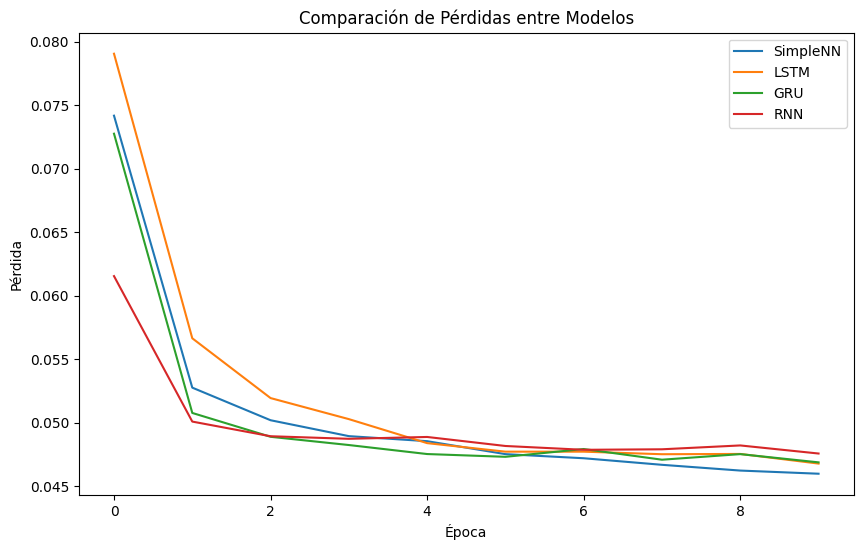

In [9]:
input_size = len(numerical_cols)
hidden_size = 64
num_layers = 2
output_size = len(numerical_cols)

# Inicializar modelos
simple_nn = SimpleNN(input_size * seq_length, hidden_size, output_size)
lstm = LSTMModel(input_size, hidden_size, num_layers, output_size)
gru = GRUModel(input_size, hidden_size, num_layers, output_size)
rnn = RNNModel(input_size, hidden_size, num_layers, output_size)

# Entrenar modelos
print("Entrenando SimpleNN...")
loss_simple_nn = train_model(simple_nn, dataloader)

print("Entrenando LSTM...")
loss_lstm = train_model(lstm, dataloader)

print("Entrenando GRU...")
loss_gru = train_model(gru, dataloader)

print("Entrenando RNN...")
loss_rnn = train_model(rnn, dataloader)

# Graficar pérdidas
plt.figure(figsize=(10, 6))
plt.plot(loss_simple_nn, label="SimpleNN")
plt.plot(loss_lstm, label="LSTM")
plt.plot(loss_gru, label="GRU")
plt.plot(loss_rnn, label="RNN")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Comparación de Pérdidas entre Modelos")
plt.legend()
plt.show()
